In [76]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
import shutil
import tifffile
import cv2
import math
from napari_correct_drift import CorrectDrift
from skimage import color
from skimage import filters
from skimage.feature import match_template
from scipy.signal import find_peaks_cwt

# MM3 req 1: Channels are mostly vertical
# MM3 Req 2: Channels have at least 20 pixels from their ends to the top and bottom edge of the image
Channel ends are in the top and bottom third of the image, regardless of orientation.
There are no artefacts in the image above and below the channels. The numbers on the mother machine can confuse the script.

In [117]:
root_dir = '/Users/noravivancogonzalez/Desktop/20240919/dimm_giTG66_glucose_1'
drift_corrected_path = napari_ready_format_drift_correct(root_dir, 'dimm', c = 0)

Applying drift: 100%|█████████████████████████| 137/137 [00:11<00:00, 11.66it/s]


Lines identified in FOV 001


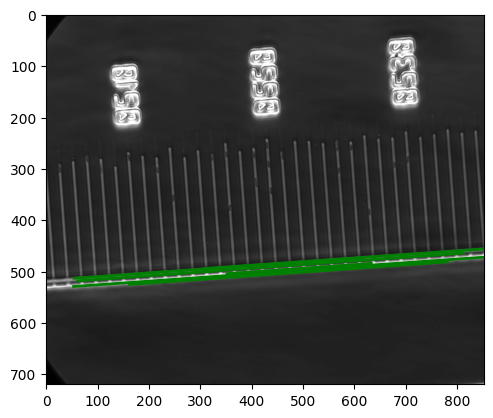

Cropping reference image
(426, 360)


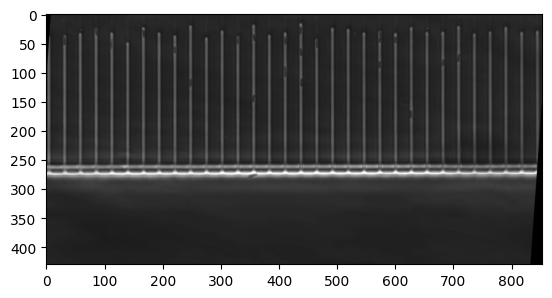

dimm_xy001.tif
Lines identified in FOV 003


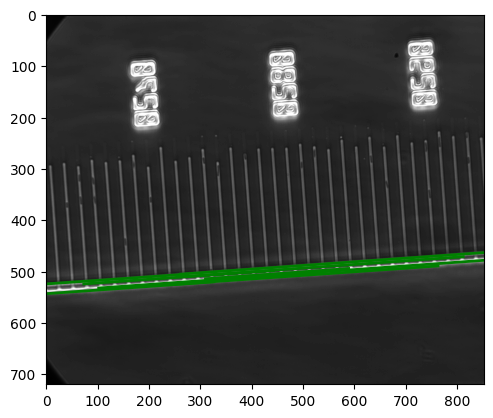

Cropping reference image
(426, 360)


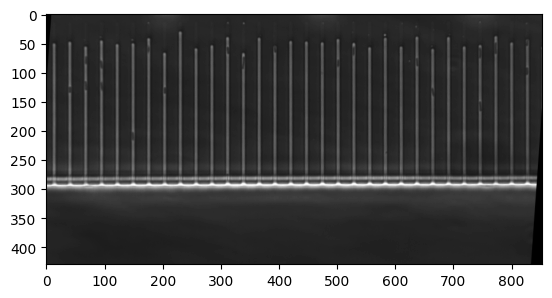

dimm_xy003.tif
Lines identified in FOV 002


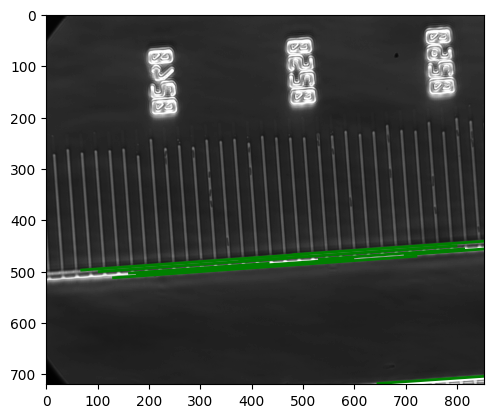

Cropping reference image
(426, 360)


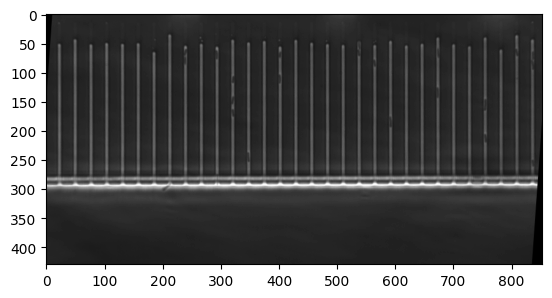

dimm_xy002.tif
Lines identified in FOV 004


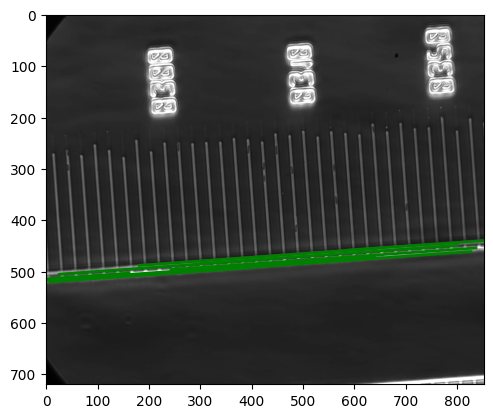

Cropping reference image
(426, 360)


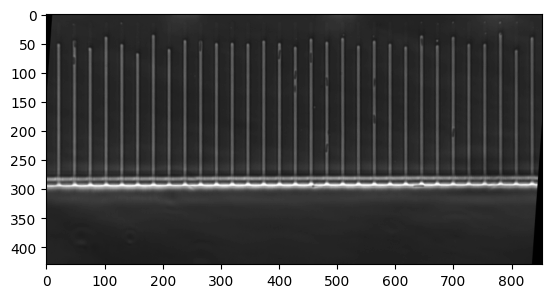

dimm_xy004.tif
Successfully rotated stack


In [203]:
path_to_rotated_images = rotate_stack(drift_corrected_path, c = 0, growth_channel_length = 280)

In [95]:
# would be useful to superimpose channel # on this mask to id which ones we want to use to subtract the microfluidic phase channel
path_to_rotated_images = '/Users/noravivancogonzalez/Desktop/20240919/dimm_giTG66_glucose_1/hyperstacked/drift_corrected/rotated'
mask_corners_dict = extract_mm_channels(path_to_rotated_images)

channels identified in FOV 003
saving sliced microfluidic channels as tcyx stacks
channels identified in FOV 002
saving sliced microfluidic channels as tcyx stacks
channels identified in FOV 001
saving sliced microfluidic channels as tcyx stacks
channels identified in FOV 004
saving sliced microfluidic channels as tcyx stacks


In [18]:
path_to_mm_channels = '/Users/noravivancogonzalez/Desktop/20240919/dimm_giTG66_glucose_1/hyperstacked/drift_corrected/rotated/mm_channels'

In [30]:
masks = load_masked_mm_channels(path_to_mm_channels)

In [97]:
mask_corners_dict
# mm_channel['FOV'] = mm_chanel: [y1, y2, x1, x2]

{'003': {41: [39, 306, 31, 51],
  68: [31, 305, 58, 78],
  95: [36, 305, 85, 105],
  122: [43, 305, 112, 132],
  150: [41, 305, 140, 160],
  177: [33, 305, 167, 187],
  204: [31, 305, 194, 214],
  231: [21, 305, 221, 241],
  258: [31, 305, 248, 268],
  285: [45, 305, 275, 295],
  312: [31, 305, 302, 322],
  339: [31, 305, 329, 349],
  366: [32, 305, 356, 376],
  394: [31, 305, 384, 404],
  421: [37, 305, 411, 431],
  448: [38, 305, 438, 458],
  475: [40, 305, 465, 485],
  502: [34, 305, 492, 512],
  529: [41, 305, 519, 539],
  556: [31, 305, 546, 566],
  583: [32, 305, 573, 593],
  611: [31, 305, 601, 621],
  638: [30, 304, 628, 648],
  665: [31, 305, 655, 675],
  692: [31, 304, 682, 702],
  719: [31, 305, 709, 729],
  746: [44, 304, 736, 756],
  774: [29, 304, 764, 784],
  801: [40, 304, 791, 811],
  828: [31, 305, 818, 838]},
 '002': {23: [42, 306, 13, 33],
  50: [34, 306, 40, 60],
  77: [43, 306, 67, 87],
  104: [41, 306, 94, 114],
  131: [42, 306, 121, 141],
  159: [41, 306, 149, 1

In [36]:
from PIL import Image, ImageDraw, ImageFont

FOV 001


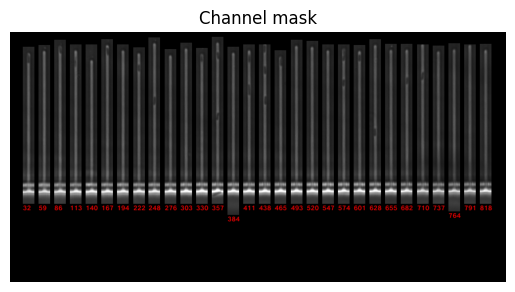

FOV 002


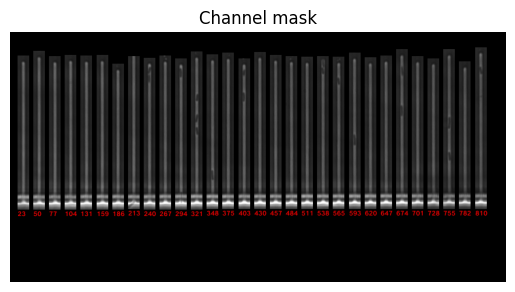

FOV 003


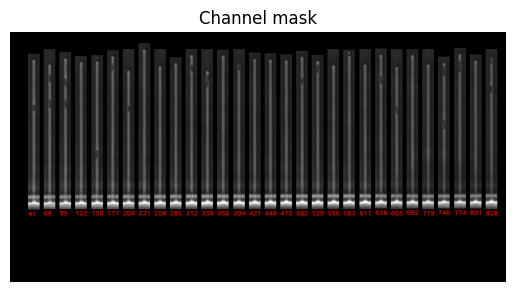

FOV 004


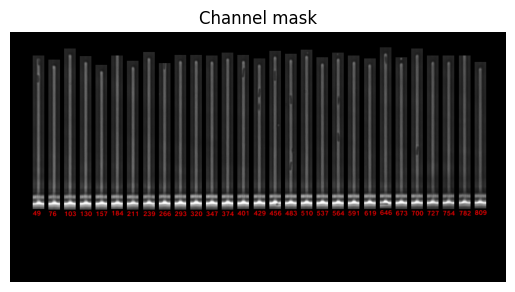

In [99]:
for FOV in masks.keys():
    file_path = masks[FOV]
    FOV_mask = tifffile.imread(file_path)
    rgb_img = color.gray2rgb(FOV_mask, channel_axis=-1)
    #convert 32 to 8 bit for PIL
    scaling_factor = 255 / (np.max(rgb_img) - np.min(rgb_img))
    scaled_img = (rgb_img - np.min(rgb_img)) * scaling_factor
    scaled_img = scaled_img.astype(np.uint8)
    # Convert the masked image to PIL format for text overlay
    pil_image = Image.fromarray(scaled_img)
    draw = ImageDraw.Draw(pil_image)
    font = ImageFont.truetype('/System/Library/Fonts/ArialHB.ttc', 15)
    for mm_channel in mask_corners_dict[FOV].keys():
        ch_text = mm_channel.astype(str)
        x = mask_corners_dict[FOV][mm_channel][2]
        y = mask_corners_dict[FOV][mm_channel][1]
        draw.text((x, y), text=ch_text, font=font, fill = 'red')
    final_image = np.array(pil_image)
    
    print('FOV '+ FOV)
    plt.imshow(final_image)
    plt.title('Channels Identified')
    plt.axis('off')  # Hide axis labels
    plt.show()

In [27]:
mm3_channels_dict = load_mm_channels(path_to_mm_channels)

# Functions for pre-processing mother machine images

In [29]:
def load_masked_mm_channels(input_dir):
    """Group files by FOV  TIFFs are stacked in tcyx format
    Returns a dictionary in the following format:
    dict[FOV] ='/path/to/tif/file'
    """
    file_groups = {}

    for filename in os.listdir(input_dir):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            match = re.match(r'FOV(\d+)_mm_channel_mask.' ,filename)
            if match:
                FOV, = match.groups()
                path = os.path.join(input_dir, filename)
                if FOV not in file_groups:
                    file_groups[FOV] = path

    return file_groups

In [ ]:
def subtract_phase(
    params: dict, cropped_channel: np.ndarray, empty_channel: np.ndarray
) -> np.ndarray:
    """subtract_phase aligns and subtracts an empty phase contrast channel (trap) from a channel containing cells.
    The subtracted image returned is the same size as the image given. It may however include
    data points around the edge that are meaningless but not marked.

    We align the empty channel to the phase channel, then subtract.

    Parameters
    image_pair : tuple of length two with; (image, empty_mean)

    Returns
    channel_subtracted : np.array
        The subtracted image

    Called by
    subtract_fov_stack
    """

    # this is for aligning the empty channel to the cell channel.
    ### Pad cropped channel.
    pad_size = params["subtract"][
        "alignment_pad"
    ]  # pixel size to use for padding (ammount that alignment could be off)
    padded_chnl = np.pad(cropped_channel, pad_size, mode="reflect")

    # ### Align channel to empty using match template.
    # use match template to get a correlation array and find the position of maximum overlap
    try:
        match_result = match_template(padded_chnl, empty_channel)
    except:
        information(
            "match_template failed. This is likely due to cropping issues with the image of the channel containing bacteria."
        )
        information(
            "Consider marking this channel as disabled in specs.yaml, or increasing the pad_size."
        )
        raise
    # get row and colum of max correlation value in correlation array
    y, x = np.unravel_index(np.argmax(match_result), match_result.shape)

    # pad the empty channel according to alignment to be overlayed on padded channel.
    empty_paddings = [
        [y, padded_chnl.shape[0] - (y + empty_channel.shape[0])],
        [x, padded_chnl.shape[1] - (x + empty_channel.shape[1])],
    ]
    aligned_empty = np.pad(empty_channel, empty_paddings, mode="reflect")
    # now trim it off so it is the same size as the original channel
    aligned_empty = aligned_empty[pad_size : -1 * pad_size, pad_size : -1 * pad_size]

    ### Compute the difference between the empty and channel phase contrast images
    # subtract cropped cell image from empty channel.
    channel_subtracted = aligned_empty.astype("int32") - cropped_channel.astype("int32")
    # channel_subtracted = cropped_channel.astype('int32') - aligned_empty.astype('int32')

    # just zero out anything less than 0. This is what Sattar does
    channel_subtracted[channel_subtracted < 0] = 0
    channel_subtracted = channel_subtracted.astype("uint16")  # change back to 16bit

    return channel_subtracted


In [4]:
def load_mm_channels(input_dir):
    """Group files by FOV and mm_channel id, TIFFs are stacked in tcyx format
    Returns a dictionary in the following format:
    dict[FOV] = {mm_channel_id : '/path/to/tif/file'}
    """
    file_groups = {}
    

    for filename in os.listdir(input_dir):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            match = re.match(r'FOV(\d+)_region_(\d+)\.' ,filename)
            if match:
              FOV, mm_channel_id = match.groups()
        
            path = os.path.join(input_dir, filename)
            if FOV not in file_groups:
              file_groups[FOV] = {}
            if mm_channel_id not in file_groups[FOV]:
              file_groups[FOV][mm_channel_id] = path

    return file_groups

In [94]:
def extract_mm_channels(path_to_tcyx_FOVs, chan_w = 10, chan_sep = 45,  crop_wp= 10, chan_lp = 10, chan_snr = 1):
    #create an output directory for microfluidic_channels
    path_to_mm_channels = os.path.join(path_to_tcyx_FOVs, 'mm_channels')
    os.makedirs(path_to_mm_channels, exist_ok=True)
    
    file_group = org_by_timepoint([path_to_tcyx_FOVs])
    mm_channel_pix = {}
    
    for position in file_group.keys():
        file_path = file_group[position]['hyperstacked']['stacked']
        FOV_stack_tcyx = tifffile.imread(file_path)
        first_phase_image = FOV_stack_tcyx[0, 0, :, :]
        
        chnl_loc_dict = find_channel_locs(first_phase_image, chan_w, chan_sep,  crop_wp, chan_snr)
        image_rows= first_phase_image.shape[0]
        image_cols= first_phase_image.shape[1]
        print("channels identified in FOV "+ position)
        consensus_mask, mask_corners_dict = make_consensus_mask(first_phase_image, chnl_loc_dict, image_rows, image_cols, crop_wp, chan_lp)
        mm_channel_pix[position] = mask_corners_dict
        masked_image = first_phase_image*consensus_mask
        filename = f'FOV{position}_mm_channel_mask.tif'
        path = os.path.join(path_to_mm_channels, filename)
        tifffile.imwrite(path, masked_image)

        
        
        print("saving sliced microfluidic channels as tcyx stacks")
        for trench in mask_corners_dict.keys():
            y1,y2, x1,x2= mask_corners_dict[trench]
            trench_region = FOV_stack_tcyx[:, :, y1:y2, x1:x2] # assuming image is stacked as tcyx
            filename = f'FOV{position}_region_{trench}.tif'
            path = os.path.join(path_to_mm_channels, filename)
            tifffile.imwrite(path, trench_region)
    return  mm_channel_pix

In [8]:
def make_consensus_mask(first_phase_image, chnl_loc_dict,image_rows, image_cols, crop_wp = 10, chan_lp = 10):
    """
    Generate consensus channel mask for a given fov.

    Parameters
    ----------
    first_phase_image: np.array of first phase image
    chnl_loc_dict: dictionary with locations of microfluidic channels
    crop_wp: int channel width padding
    crop_lp: int channel_width padding

    Returns
    -------
    normalized mask of identified mm channels and
    dictionary containing coordinates of each microfluidic channel in an FOV
    """

    mask_corners_dict = {}

    consensus_mask = np.zeros([image_rows, image_cols])  # mask for labeling entire image
    # for each trench in each image make a single mask
    img_chnl_mask = np.zeros([image_rows, image_cols])
    
    # and add the channel/peak mask to it
    # Assuming chnl_loc_dict is a NumPy array
    for chnl_peak in chnl_loc_dict:
        peak_ends = chnl_loc_dict[chnl_peak]
        # pull out the peak location and top and bottom location
        # and expand by padding 
        x1 = max(chnl_peak- crop_wp, 0)
        x2 = min(chnl_peak + crop_wp, image_cols)
        y1 = max(peak_ends["closed_end_px"] - chan_lp, 0)
        y2 = min(peak_ends["open_end_px"] + chan_lp, image_rows)
        mask_corners_dict[chnl_peak] = [y1, y2, x1, x2]
    
        # add it to the mask for this image
        img_chnl_mask[y1:y2, x1:x2] = 1
    
    # add it to the consensus mask
    consensus_mask += img_chnl_mask
    
    # Normalize consensus mask between 0 and 1.
    consensus_mask = consensus_mask.astype("float32") / float(np.amax(consensus_mask))
    return consensus_mask, mask_corners_dict

In [9]:
def find_channel_locs(image_data, chan_w = 10, chan_sep = 45,  crop_wp= 10, chan_snr = 1):
    """Finds the location of channels from a phase contrast image. The channels are returned in
    a dictionary where the key is the x position of the channel in pixel and the value is a
    dicionary with the open and closed end in pixels in y.

    image data is an np.array of the first phase image of the FOV


    """

    # Detect peaks in the x projection (i.e. find the channels)
    projection_x = image_data.sum(axis=0).astype(np.int32)
    # find_peaks_cwt is a function which attempts to find the peaks in a 1-D array by
    # convolving it with a wave. here the wave is the default Mexican hat wave
    # but the minimum signal to noise ratio is specified
    # *** The range here should be a parameter or changed to a fraction.
    peaks = find_peaks_cwt(
        projection_x, np.arange(chan_w - 5, chan_w + 5), min_snr=chan_snr
    )

    # If the left-most peak position is within half of a channel separation,
    # discard the channel from the list.
    if peaks[0] < (chan_sep / 2):
        peaks = peaks[1:]
    # If the diference between the right-most peak position and the right edge
    # of the image is less than half of a channel separation, discard the channel.
    if image_data.shape[1] - peaks[-1] < (chan_sep / 2):
        peaks = peaks[:-1]

    # Find the average channel ends for the y-projected image
    projection_y = image_data.sum(axis=1)
    # find derivative, must use int32 because it was unsigned 16b before.
    proj_y_d = np.diff(projection_y.astype(np.int32))
    # use the top third to look for closed end, is pixel location of highest deriv
    onethirdpoint_y = int(projection_y.shape[0] / 3.0)
    default_closed_end_px = proj_y_d[:onethirdpoint_y].argmax()
    # use bottom third to look for open end, pixel location of lowest deriv
    twothirdpoint_y = int(projection_y.shape[0] * 2.0 / 3.0)
    default_open_end_px = twothirdpoint_y + proj_y_d[twothirdpoint_y:].argmin()
    default_length = default_open_end_px - default_closed_end_px  # used for checks

    # go through peaks and assign information
    # dict for channel dimensions
    chnl_loc_dict = {}
    # key is peak location, value is dict with {'closed_end_px': px, 'open_end_px': px}

    for peak in peaks:
        # set defaults
        chnl_loc_dict[peak] = {
            "closed_end_px": default_closed_end_px,
            "open_end_px": default_open_end_px,
        }
        # redo the previous y projection finding with just this channel
        channel_slice = image_data[:, peak - crop_wp : peak + crop_wp]
        slice_projection_y = channel_slice.sum(axis=1)
        slice_proj_y_d = np.diff(slice_projection_y.astype(np.int32))
        slice_closed_end_px = slice_proj_y_d[:onethirdpoint_y].argmax()
        slice_open_end_px = twothirdpoint_y + slice_proj_y_d[twothirdpoint_y:].argmin()
        slice_length = slice_open_end_px - slice_closed_end_px

        # check if these values make sense. If so, use them. If not, use default
        # make sure lenght is not 30 pixels bigger or smaller than default
        # *** This 15 should probably be a parameter or at least changed to a fraction.
        if slice_length + 15 < default_length or slice_length - 15 > default_length:
            continue
        # make sure ends are greater than 15 pixels from image edge
        if slice_closed_end_px < 15 or slice_open_end_px > image_data.shape[0] - 15:
            continue

        # if you made it to this point then update the entry
        chnl_loc_dict[peak] = {
            "closed_end_px": slice_closed_end_px,
            "open_end_px": slice_open_end_px,
        }

    return chnl_loc_dict

In [10]:
def midpoint_distance(line, center):
    # Function to calculate line midpoint distance
    midpoint_x = (line[0][0] + line[0][2]) / 2
    midpoint_y = (line[0][1] + line[0][3]) / 2
    distance = np.sqrt((midpoint_x - center[0])**2 + (midpoint_y - center[1])**2)
    return distance

def crop_around_central_flow(h_lines, w, h, growth_channel_length= 150):
    threshold = 200 # distance from center of image
    center_x, center_y = w // 2, h // 2
    if h_lines is not None:
        # Filter lines based on distance
        filtered_lines = []
        for line in h_lines:
            distance = midpoint_distance(line, (center_x, center_y))
            if distance <= threshold:
                filtered_lines.append(line)
        x1, y1, x2, y2 = filtered_lines[0][0]

        # Determine crop boundaries
        crop_start = max(y1 - growth_channel_length, 0)
        crop_end = min(y1 + 150, h)

        print('Cropping reference image')

        return crop_start, crop_end

    else:
        print('Warning: horizontal lines were not detected')
        return None

In [11]:
def rotate_stack(path_to_stack, c = 0, growth_channel_length = 295):
    """Args:
    path_to_stack: Path to stack of cyx format files, in string format
    c: Phase channel index in integer format, default = 0
    orientation: Orientation of lines to use to rotate and crop files, 
    value is a string indicating "horizontal" or "vertical". Defualt is vertical.
    growth_channel_length: length in pixels of growth channel. 
    Shorter channels are approx 130 pixels. 150 is default.
    """
    ## I want to make this work in tcyx files, because I can skip unstacking the drift corrected files if I isolate trenches with my own code and don't use napari-mm3
    #create an output directory for the rotated files
    path_to_rotated_images = os.path.join(path_to_stack, 'rotated')
    os.makedirs(path_to_rotated_images, exist_ok=True)

    for position in file_groups.keys():
        file_path = file_groups[position]['hyperstacked']['stacked']
        filename = os.path.basename(file_path)
        stacked_img = tifffile.imread(file_path)
        ref_phase_img  = stacked_img[0, c, :, :] # [t, c, y, x]
        print('Lines identified in FOV ' + position)
        h, w = ref_phase_img.shape
        horizontal_lines, vertical_lines = id_lines(ref_phase_img)
        plot_lines(ref_phase_img, horizontal_lines)
        rotation_angle = calculate_rotation_angle(ref_phase_img, horizontal_lines)
        ref_rotated_image = apply_image_rotation(ref_phase_img, rotation_angle)
        rot_horizontal_lines, rot_vertical_lines = id_lines(ref_rotated_image)
        crop_start, crop_end = crop_around_central_flow(rot_horizontal_lines, w, h, growth_channel_length)
        rotated_stack = apply_image_rotation(stacked_img, rotation_angle)
        cropped_stack = rotated_stack[:,:, crop_start:crop_end, :]
        plt.figure()
        plt.imshow(cropped_stack[0,c, :, :], cmap='gray')
        plt.show()
        print(filename)
        new_filename = f'rotated_{filename}'
        new_path = os.path.join(path_to_rotated_images, new_filename)
        tifffile.imwrite(new_path, cropped_stack)
    print('Successfully rotated stack')
    return path_to_rotated_images

In [12]:
def detect_clear_image(image):
    laplacian_image = filters.laplace(image)
    blur_score = np.var(laplacian_image)
    if blur_score >= 0:
        return True

In [13]:
def napari_ready_format_drift_correct(root_dir, experiment_name, c = 0):
    """ 
    Arg
    root_dir: parent directory containing multiple 'Pos#' directories, 
    each containing tif files of single timepoints and channels of the given position. 
    File name is default from the Covert lab microscope.
    experiment_name: unique id to label output files
    c = int representing phase channel index
    output: drift corrected files across multiple positions and timepoints. Found within
    'cyx_files_for_mm3' directory
    
    """

    hyperstacked_path = os.path.join(root_dir, 'hyperstacked')
    drift_corrected_path = os.path.join(hyperstacked_path, 'drift_corrected')
    output_dir_path = os.path.join(drift_corrected_path, 'cyx_files_for_mm3')

    time_dict = hyperstack_tif_tcyx(root_dir, experiment_name)
    
    drift_correction_napari(hyperstacked_path)
    
    unstack_tcyx_to_cyx(drift_corrected_path, time_dict)
    
    return drift_corrected_path

def hyperstack_tif_tcyx(root_dir, experiment_name, c = 0):
    
    """Renames TIFF files without deleting originals.
    Args:
    input_dir: parent directory.
    experiment_name: The desired experiment name.
    """
    root = Path(root_dir)
    input_dirs = [str(path) for path in root.glob('**//Pos*') if path.is_dir()]

    # Create output directory if it doesn't exist
    output_dir_path = os.path.join(root_dir, 'renamed')
    os.makedirs(output_dir_path, exist_ok=True)
    stacked_path = os.path.join(root_dir, 'stacked')
    os.makedirs(stacked_path, exist_ok=True)
    hyperstacked_path = os.path.join(root_dir, 'hyperstacked')
    os.makedirs(hyperstacked_path, exist_ok=True)

    time_clear_dict = {}

    file_groups = org_by_timepoint(input_dirs)
    for position, time in sorted(file_groups.items()):
        time_clear_dict[position] ={}
        time_stacked_image_data = []
        for time, channels in sorted(time.items()):
            image_data = []
            for channel, image_path in sorted(channels.items()):
                new_filename = f'{experiment_name}_t{time:04.0f}xy{position}c{channel}.tif'
                new_path = os.path.join(output_dir_path, new_filename)
                try:
                    # Copy the file to the new path
                    shutil.copy(str(image_path), str(new_path))
                    channel_image = tifffile.TiffFile(new_path).asarray() 
                    image_data.append(channel_image)
                    
                except OSError as e:
                    print(f'Error copying file: {e}')
            stacked_image = np.stack(image_data, axis=0)  # Assuming channels are the first dimension
            output_stacked_file = Path(stacked_path) / f"{experiment_name}_t{time:04.0f}xy{position}.tif"
            tifffile.imwrite(str(output_stacked_file), stacked_image)
            phase_image = stacked_image[c, :, :]
            if detect_clear_image(phase_image): # only time stack clear images
                time_stacked_image_data.append(stacked_image) 
                time_clear_dict[position][time] = 'clear'
            else:
                time_clear_dict[position][time] = 'blurry'
                print('blurry')
        hyperstacked_image = np.stack(time_stacked_image_data, axis=0)  # time as the first dimension
        output_hyperstacked_file = Path(hyperstacked_path) / f"{experiment_name}_xy{position}.tif"
        tifffile.imwrite(str(output_hyperstacked_file), hyperstacked_image)
        
    return time_clear_dict

def drift_correction_napari(hyperstacked_path):
    output_dir_path = os.path.join(hyperstacked_path, 'drift_corrected')
    os.makedirs(output_dir_path, exist_ok=True)
    
    for filename in os.listdir(hyperstacked_path):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            if re.match(r'(.*)_xy(\d+)\.' ,filename):
                match = re.match(r'(.*)_xy(\d+)\.' ,filename)
                experiment, position = match.groups()
                img_path = os.path.join(hyperstacked_path, filename)
                hyperstacked_img = tifffile.imread(img_path)
                # multi-channel 2D-movie
                cd = CorrectDrift(hyperstacked_img, "tcyx")
                # estimate drift table
                drifts = cd.estimate_drift(t0=0, channel=0)
                # correct drift
                img_cor = cd.apply_drifts(drifts)
                img_cor_file = Path(output_dir_path) / f"drift_cor_{experiment}_xy{position}.tif"
                tifffile.imwrite(str(img_cor_file), img_cor)

def org_by_timepoint(input_dirs):
    
    """Group files by time and channel id, it does not take into account the z axis
    Reads in files in the format exported by the Covert lab scope, 
    which is as follows: 'img_channel(\d+)_position(\d+)_time(\d+)_z(\d+)\.'

    Returns a dictionary in the following format:
    dict[time_frame] = {channel_id : '/path/to/tif/file'}
    """

    time = 'hyperstacked'
    channel = 'stacked'
    position = '0'
    
    file_groups = {}
    
    for input_dir in input_dirs:
        for filename in os.listdir(input_dir):
            if filename.endswith('.tif') or filename.endswith('.tiff'):
                match = re.match(r'img_channel(\d+)_position(\d+)_time(\d+)_z(\d+)\.' ,filename)
                if match:
                  channel, position, time, z = match.groups()
                  time = int(time)
                elif re.match(r'(.*)_t(\d+)xy(\d+)\.',filename):
                    match = re.match(r'(.*)_t(\d+)xy(\d+)\.',filename)
                    experiment, time, position = match.groups()
                    time = int(time)
                else:
                    match = re.match(r'(.*)_xy(\d+)\.' ,filename)
                    if match:
                        experiment, position = match.groups()
                path = os.path.join(input_dir, filename)
                if position not in file_groups:
                  file_groups[position] = {}
                if time not in file_groups[position]:
                  file_groups[position][time] = {}
                if channel not in file_groups[position][time]:
                  file_groups[position][time][channel] = path
    
    return file_groups

def unstack_tcyx_to_cyx(path_to_hyperstacked, time_clear_dict):
    
    """
    input_dir: directory where movies are hyperstacked as tcyx
    output_dir: The output directory for TIFF files stacked as cyx
    """

    # Create output directory if it doesn't exist
    output_dir_path = os.path.join(path_to_hyperstacked, 'cyx_files_for_mm3')
    os.makedirs(output_dir_path, exist_ok=True)
    

    file_groups = org_by_timepoint([path_to_hyperstacked])
    for position, time in sorted(file_groups.items()):
        for time, channels in sorted(time.items()):
            for channel, image_path in sorted(channels.items()):
                filename = os.path.basename(image_path)
                match = re.match(r'(.*)_xy(\d+)\.' ,filename)
                if match:
                    experiment, position = match.groups()
                    hyperstacked_img = tifffile.imread(image_path)
                    real_times = [key for key, val in time_clear_dict[position].items() if val == 'clear']
                    index_times = [i for i in range(0, hyperstacked_img.shape[0], 1)]
                    index_to_real_time = dict(zip(index_times, real_times))
    
                    for index in range(hyperstacked_img.shape[0]):
                        cyx_image = hyperstacked_img[index, :, :, :]
                        real_time = index_to_real_time[index]
                        output_cyx_file = Path(output_dir_path) / f"{experiment}_t{real_time:04.0f}xy{position}.tif"
                        tifffile.imwrite(str(output_cyx_file), cyx_image)
                        

def plot_lines_across_FOVs(path_to_stack, c = 0):
    
    """Args:
    path_to_stack: Path to stack of cyx format files, in string format
    c: Phase channel index in integer format, default = 0
    Output is a series of plotted images with identified 
    horizontal or vertical lines across FOVs/positions
    """
    file_groups = org_by_timepoint([path_to_stack])

    for position in file_groups.keys():
        earliest_timepoint = min(file_groups[position].keys())
        first_file_path = file_groups[position][earliest_timepoint]['stacked']
        ref_img = tifffile.imread(first_file_path)
        ref_phase_img = ref_img[c, :, :]
        horizontal_lines, vertical_lines = id_lines(ref_phase_img)
        print('Lines identified in FOV ' + position)
        print('Horizontal lines')
        plot_lines(ref_phase_img, horizontal_lines)

def calculate_line_angle(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    angle = np.arctan2(dy, dx) * 180 / np.pi
    return angle

def find_lines(img):
    normalized_img = (img / img.max() * 255).astype(np.uint8)
    edges = cv2.Canny(normalized_img, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)
    return lines
    
def id_lines(img):
    lines = find_lines(img)
    h_lines = []
    v_lines = []
    count = 0
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = calculate_line_angle(x1, y1, x2, y2)
            if abs(angle) < 30:  # Adjust threshold as needed
                h_lines.append(line)
                count+= 1
            elif 60 <= abs(angle) <= 120:  # Adjust threshold as needed
                v_lines.append(line)
                count+= 1
            if count >= 50:
                break
    return h_lines, v_lines


def calculate_rotation_angle(img, lines):
    """calculate rotation angle based on phase image"""
    angles = []
    for line in lines:
        # Calculate angle of the line
        x1, y1, x2, y2 = line[0]
        angle = calculate_line_angle(x1, y1, x2, y2)
        angles.append(abs(angle))
    average_angle = sum(angles) / len(angles)
    return -average_angle

def plot_lines(original_img, lines):
    plt.figure()
    plt.imshow(original_img, cmap='gray')
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            plt.plot([x1, x2], [y1, y2], color='green', linewidth=2) 
        plt.show()


def apply_image_rotation(image_stack, rotation_angle):
    """Applies rotation to an image stacked as cyx.

    Args:
        image: image in Grey or BGR format for OpenCV 
        rotation_angle: The rotation angle in degrees.

    Returns:
        Rotated image in BGR format.
    """
    rotated_stack = np.zeros_like(image_stack)
    h = None
    w = None
    #assumes tcyx format
    if image_stack.ndim == 4:
        h, w = image_stack.shape[2:]
        center = (w // 2, h // 2)
        print(center)
        M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
        for time in range(image_stack.shape[0]):
            for channel in range(image_stack.shape[1]):
                rotated_stack[time, channel] = cv2.warpAffine(image_stack[time, channel], M, (w, h))
    
    elif image_stack.ndim == 3:
        h, w = image_stack.shape[1:]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
        for channel in range(image_stack.shape[0]):
            rotated_stack[channel] = cv2.warpAffine(image_stack[channel], M, (w, h))
    
    elif image_stack.ndim == 2:
        h, w = image_stack.shape
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
        rotated_stack = cv2.warpAffine(image_stack, M, (w, h))

    return rotated_stack